### Import required library and data set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import r2_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel("Data_Train.xlsx")

In [4]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [6]:
df.isnull().sum()    #there is one missing value in Route & Total_Stops

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [7]:
df.shape

(10683, 11)

### EDA 

<AxesSubplot:xlabel='Price', ylabel='Airline'>

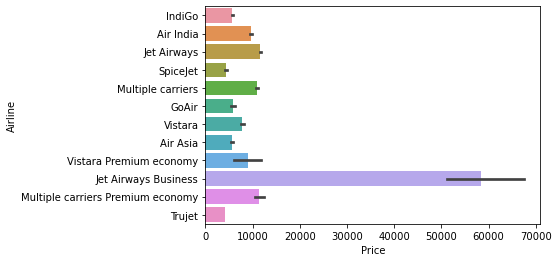

In [8]:
sns.barplot(df["Price"],df["Airline"])

<AxesSubplot:xlabel='Total_Stops', ylabel='Price'>

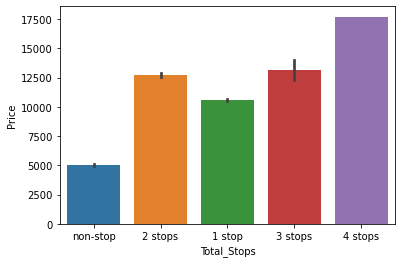

In [9]:
sns.barplot(df["Total_Stops"],df["Price"])

<AxesSubplot:xlabel='Destination', ylabel='Price'>

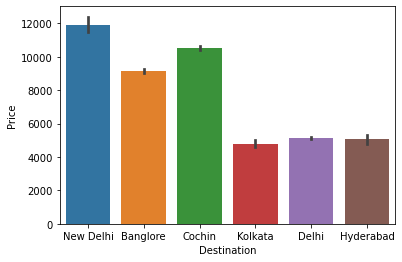

In [10]:
sns.barplot(df["Destination"],df["Price"])

<AxesSubplot:xlabel='Date_of_Journey', ylabel='Price'>

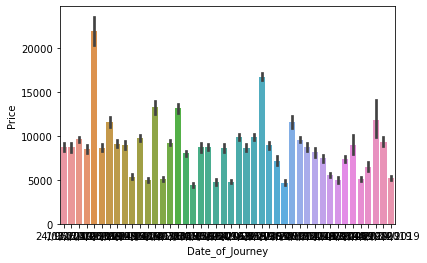

In [11]:
sns.barplot(df["Date_of_Journey"],df["Price"])

## Feature Engineering

In [12]:
# Dropping one missing value 
df = df.dropna()

In [13]:
df["Additional_Info"].value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [14]:
#Additional info contains 80% no data and hence we are dropping it, Route and Total_stops have same information, hence dropping Route
df.drop(["Additional_Info","Route"],axis = 1,inplace =True)

In [15]:
# Label encoding for Total_Stops
df["Total_Stops"] = df["Total_Stops"].replace({"non-stop":0,"1 stop":1,"2 stops":2,"3 stops":3,"4 stops":4})

In [16]:
# Handling features containing date and time
df['Jrny_month'] = pd.DatetimeIndex(df['Date_of_Journey']).month
df['Jrny_day'] = pd.DatetimeIndex(df['Date_of_Journey']).day
df['Dep_Time_hr'] = pd.DatetimeIndex(df['Dep_Time']).hour
df['Dep_Time_min'] = (pd.DatetimeIndex(df['Dep_Time']).minute)
df["Arrival_Time_hr"] =pd.DatetimeIndex(df["Arrival_Time"]).hour
df["Arrival_Time_min"] =(pd.DatetimeIndex(df["Arrival_Time"]).minute)
df['Duration_hour'] =((pd.to_timedelta(df['Duration']).dt.seconds) / 3600).astype(float)
df.drop(["Date_of_Journey","Dep_Time","Arrival_Time","Duration"],axis=1,inplace=True)

In [17]:
df.head()

,Airline,Source,Destination,Total_Stops,Price,Jrny_month,Jrny_day,Dep_Time_hr,Dep_Time_min,Arrival_Time_hr,Arrival_Time_min,Duration_hour
0,IndiGo,Banglore,New Delhi,0,3897,3,24,22,20,1,10,2.833333
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7.416667
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19.000000
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5.416667
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,35,4.750000


In [18]:
# one hot encoding 
df = pd.get_dummies(df,drop_first = True)

In [19]:
df.head()

,Total_Stops,Price,Jrny_month,Jrny_day,Dep_Time_hr,Dep_Time_min,Arrival_Time_hr,Arrival_Time_min,Duration_hour,Airline_Air India,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,3,24,22,20,1,10,2.833333,0,...,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,5,50,13,15,7.416667,1,...,0,0,0,1,0,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19.000000,0,...,0,0,1,0,0,1,0,0,0,0
3,1,6218,12,5,18,5,23,30,5.416667,0,...,0,0,0,1,0,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4.750000,0,...,0,0,0,0,0,0,0,0,0,1


In [20]:
df.corr()["Price"]

Total_Stops                                  0.603897
Price                                        1.000000
Jrny_month                                   0.010705
Jrny_day                                    -0.165448
Dep_Time_hr                                  0.006799
Dep_Time_min                                -0.024458
Arrival_Time_hr                              0.024244
Arrival_Time_min                            -0.086155
Duration_hour                                0.449677
Airline_Air India                            0.050432
Airline_GoAir                               -0.095151
Airline_IndiGo                              -0.361070
Airline_Jet Airways                          0.416124
Airline_Jet Airways Business                 0.253303
Airline_Multiple carriers                    0.139793
Airline_Multiple carriers Premium economy    0.017650
Airline_SpiceJet                            -0.296565
Airline_Trujet                              -0.010381
Airline_Vistara             

### Feature Selection and Feature Scaling

In [21]:
X = df.drop(["Price"],axis=1)
Y = df["Price"]
X

,Total_Stops,Jrny_month,Jrny_day,Dep_Time_hr,Dep_Time_min,Arrival_Time_hr,Arrival_Time_min,Duration_hour,Airline_Air India,Airline_GoAir,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3,24,22,20,1,10,2.833333,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,5,5,50,13,15,7.416667,1,0,...,0,0,0,1,0,0,0,0,0,0
2,2,9,6,9,25,4,25,19.000000,0,0,...,0,0,1,0,0,1,0,0,0,0
3,1,12,5,18,5,23,30,5.416667,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,1,3,16,50,21,35,4.750000,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0,9,4,19,55,22,25,2.500000,0,0,...,0,0,0,1,0,0,0,0,0,0
10679,0,4,27,20,45,23,20,2.583333,1,0,...,0,0,0,1,0,0,0,0,0,0
10680,0,4,27,8,20,11,20,3.000000,0,0,...,0,0,0,0,0,0,1,0,0,0
10681,0,1,3,11,30,14,10,2.666667,0,0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

### Trian & Test split

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,train_size=0.75,random_state=42)

## Model Building 

### Using Random Forest Regressor

In [24]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [25]:
y_pred = model.predict(X_test)

In [26]:
r2_score(y_test,y_pred)

0.8309725336808672

In [27]:
model.score(X_train, y_train)  #Accuracy on Train data

0.953279807014142

#### Hyper - Parameter tunning 

In [28]:
from sklearn.model_selection import KFold

In [29]:
#Hyper Parameter Tuning
params ={"n_estimators": [100,150,50],
         "max_features":["auto","sqrt"],
        "max_depth":[20,30,40,10],      
        }

In [30]:
kfold = KFold(n_splits=10)
model = RandomForestRegressor()
grid = GridSearchCV(estimator =model,param_grid = params,cv = kfold)
cv_fit = grid.fit(X_train,y_train)

In [31]:
print('Best : {}, using {}'.format(cv_fit.best_score_,cv_fit.best_params_))

Best : 0.8111637021920227, using {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 150}


In [32]:
model_final = RandomForestRegressor(criterion= 'mse', n_estimators= 100,max_depth=10,max_features='auto')
model_final.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', max_depth=10)

### Save our model using Pickle

In [33]:
import pickle

In [34]:
filename = 'flight_pred'

In [35]:
pickle.dump(model_final,open(filename,'wb'))

In [36]:
model_load = pickle.load(open(filename,'rb'))

In [37]:
prediction = model_load.predict(X_test)

In [38]:
accuracy = r2_score(y_test,prediction)

In [39]:
print("Accuracy on test data :", accuracy)

Accuracy on test data : 0.8374479741756324


### Plot for train and test accurcy

In [40]:
from sklearn.model_selection import learning_curve

In [41]:
size, train,validate = learning_curve(model_load, X, Y, cv=10, scoring='r2')

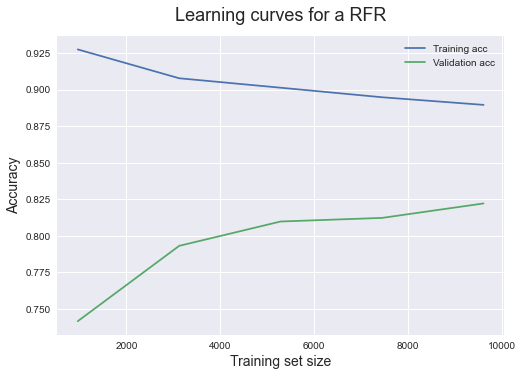

In [42]:
train_mean = train.mean(axis = 1)
validate_mean = validate.mean(axis =1)
plt.style.use('seaborn')
plt.plot(size, train_mean, label = 'Training acc')
plt.plot(size, validate_mean, label = 'Validation acc')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a RFR', fontsize = 18, y = 1.03)
plt.legend()